## Libraries

In [10]:
# import libraries we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.calibration import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np
from pathlib import Path

## Datasets

In [11]:
# Set up file paths
BASE_DIR = Path("./DataSet/UNSW-NB15") 
BASE_DIR2 = Path("./DataSet/CIC UNSW-NB15 Augmented Dataset")
# UNSW-NB15
UNSW_TRAIN_FILE = BASE_DIR / "UNSW_NB15_training-set.csv"
UNSW_TEST_FILE  = BASE_DIR / "UNSW_NB15_testing-set.csv"

# CIC UNSW-NB15 Augmented
CIC_FEATURE_FILE = BASE_DIR2 / "Data.csv"      # All feature columns
CIC_LABEL_FILE   = BASE_DIR2 / "Label.csv"     # Target column

# Load the UNSW-NB15 training and testing datasets
unsw_train_df = pd.read_csv(UNSW_TRAIN_FILE)
unsw_test_df  = pd.read_csv(UNSW_TEST_FILE)

# Load the CIC Augmented dataset
cic_features_df = pd.read_csv(CIC_FEATURE_FILE)
cic_labels_df   = pd.read_csv(CIC_LABEL_FILE)
# Combine features + labels into one DataFrame
cic_augmented_df = pd.concat([cic_features_df, cic_labels_df], axis=1)

## Data Pre-Processing
### Distribution Pie Chart

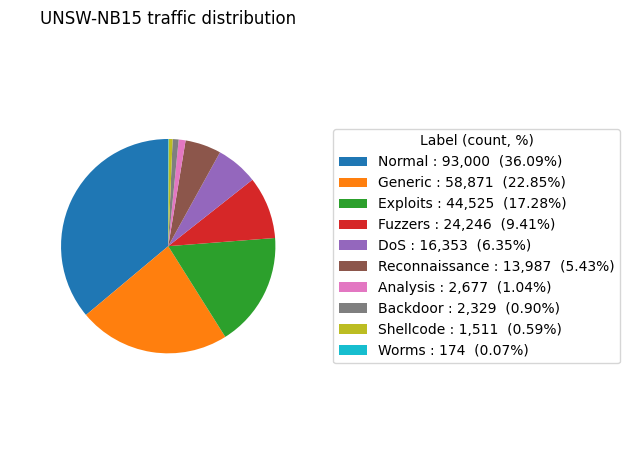

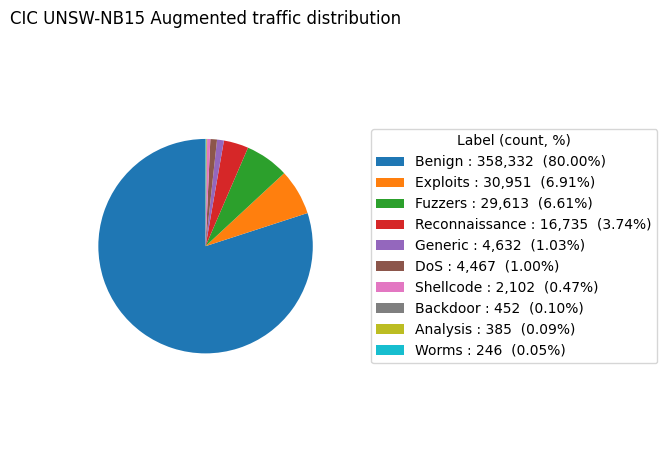

In [12]:
# ------------------------------------------------------------
# 1) Pie chart for UNSW-NB15
# ------------------------------------------------------------

# Combine the UNSW‑NB15 training and testing datasets for pie chart visualization
unsw_full_df  = pd.concat([unsw_train_df, unsw_test_df], ignore_index=True)

# Pie chart for UNSW-NB15
attack_counts = (
    unsw_full_df["attack_cat"]
    .fillna("Unknown")
    .value_counts()
    .sort_values(ascending=False)
)

total_unsw = attack_counts.sum()
fig1, ax1 = plt.subplots()
patches1, _ = ax1.pie(attack_counts, startangle=90, labels=None) 
legend_labels1 = [
    f"{cat} : {cnt:,}  ({cnt/total_unsw:.2%})"
    for cat, cnt in attack_counts.items()
]
ax1.set_title("UNSW-NB15 traffic distribution")
ax1.legend(
    patches1, legend_labels1,
    title="Label (count, %)",
    loc="center left", bbox_to_anchor=(1, 0.5)
)
ax1.axis("equal")
fig1.tight_layout()

# ------------------------------------------------------------
# 2) Pie chart for CIC UNSW-NB15 Augmented
# ------------------------------------------------------------
label_map = {
    0: "Benign", 1: "Analysis", 2: "Backdoor", 3: "DoS", 4: "Exploits",
    5: "Fuzzers", 6: "Generic", 7: "Reconnaissance", 8: "Shellcode", 9: "Worms"
}
cic_augmented_df["LabelName"] = cic_augmented_df["Label"].map(label_map)
cic_counts = (
    cic_augmented_df["LabelName"]
    .fillna("Unknown")
    .value_counts()
    .sort_values(ascending=False)
)

total_cic = cic_counts.sum()
fig2, ax2 = plt.subplots()
patches2, _ = ax2.pie(cic_counts, startangle=90, labels=None)
legend_labels2 = [
    f"{lbl} : {cnt:,}  ({cnt/total_cic:.2%})"
    for lbl, cnt in cic_counts.items()
]
ax2.set_title("CIC UNSW-NB15 Augmented traffic distribution")
ax2.legend(
    patches2, legend_labels2,
    title="Label (count, %)",
    loc="center left", bbox_to_anchor=(1, 0.5)
)
ax2.axis("equal")
fig2.tight_layout()

### NA Check

In [13]:
# NA Check
def na_report(df, label):
    na_counts = df.isna().sum()
    total_rows = len(df)
    print(f"\n{label}:")
    if (na_counts == 0).all():
        print("  ✔ No missing values detected.")
    else:
        for col, cnt in na_counts[na_counts > 0].sort_values(ascending=False).items():
            pct = cnt / total_rows * 100
            print(f"  {col:<30}: {cnt:,}  ({pct:.2f}%)")

# UNSW-NB15 
na_report(unsw_full_df, "UNSW-NB15")

# CIC UNSW-NB15 Augmented
na_report(cic_augmented_df, "CIC UNSW-NB15 Augmented")


UNSW-NB15:
  ✔ No missing values detected.

CIC UNSW-NB15 Augmented:
  ✔ No missing values detected.


### Correlation Heatmap

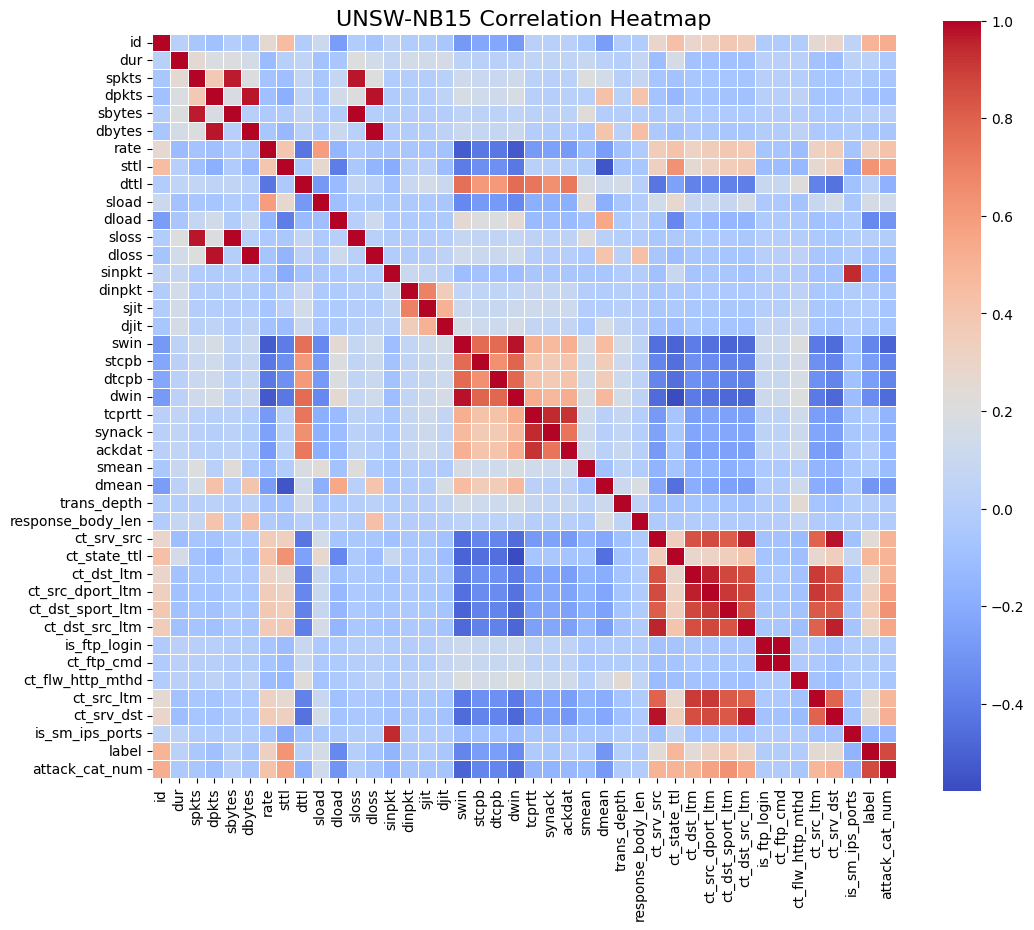

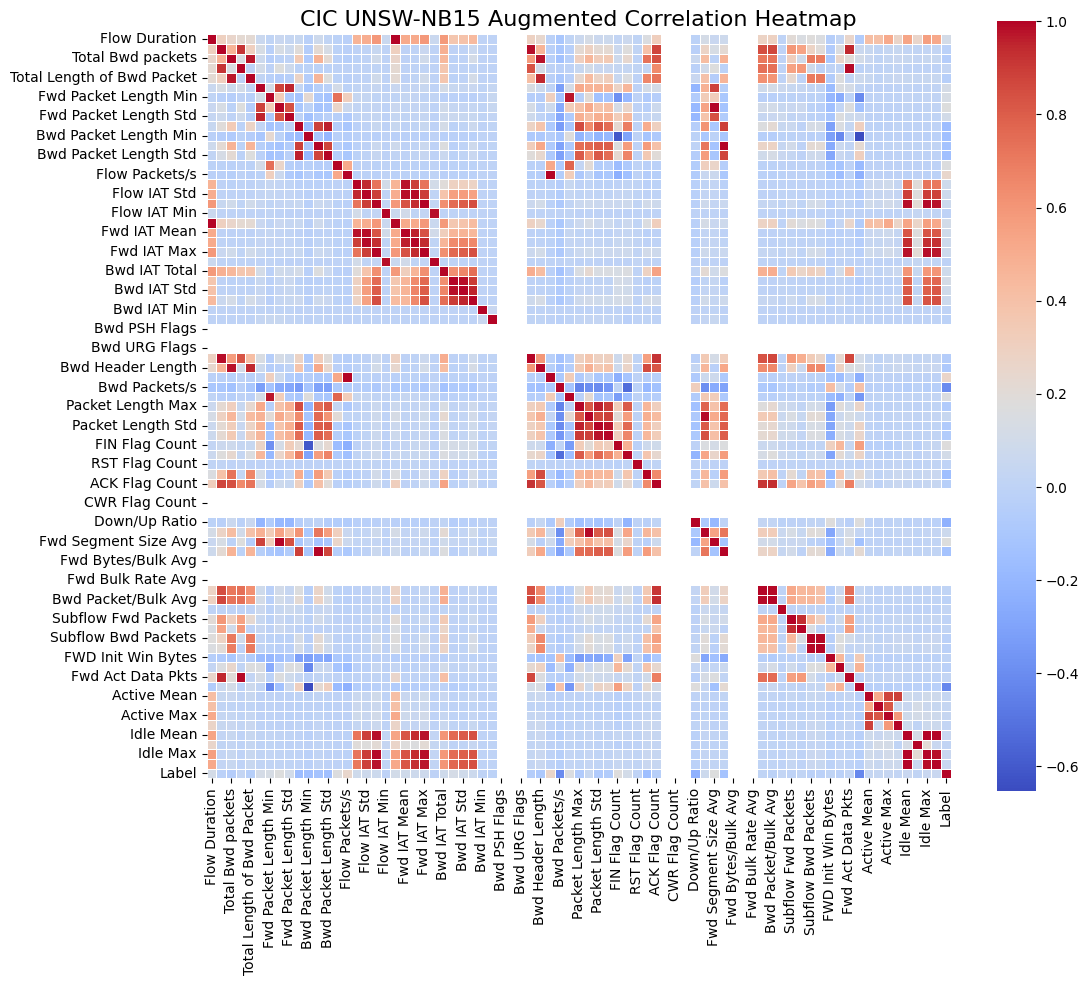

In [14]:
# Plot correlation heatmap
def plot_corr_heatmap(df, title):
    num_df = df.select_dtypes(include=[np.number])
    corr = num_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Draw the heatmap
    sns.heatmap(corr, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

    # Add title
    plt.title(title, fontsize=16)

    # Display the heatmap
    plt.show()

# Heatmap for UNSW-NB15 combined dataset
unsw_full_df["attack_cat_num"] = pd.factorize(
    unsw_full_df["attack_cat"].fillna("Unknown")
)[0]
plot_corr_heatmap(
    unsw_full_df,
    title="UNSW-NB15 Correlation Heatmap"
)

# Heatmap for CIC UNSW-NB15 Augmented dataset 
plot_corr_heatmap(
    cic_augmented_df,
    title="CIC UNSW-NB15 Augmented Correlation Heatmap"
)

### Feature Selection

In [15]:
# HELPER Functions

# remove constant-valued columns
def constant_cols(df):
    return [c for c in df.columns if df[c].nunique() <= 1]

# ANOVA + Pearson-ρ correlation
def anova_corr_table(X, y):
    F, p = f_classif(X, y)
    rho   = [np.corrcoef(X[c], y)[0, 1] for c in X.columns]
    return pd.DataFrame(
        {"feature": X.columns, "F": F, "p": p, "corr": rho,
         "abs_corr": np.abs(rho)}
    )

# select features based on ANOVA and Pearson-ρ
def select_and_report(df_stats, F_alpha=2000, rho_thr=0.10, label=""):
    keep = df_stats[(df_stats["F"] > F_alpha) & (df_stats["abs_corr"] >= rho_thr)]
    print(f"\n{label}  – retained features ({len(keep)}):")
    print(keep[["feature", "F", "corr"]]
          .sort_values("F", ascending=False)
          .to_string(index=False))

# 1)  UNSW-NB15
le_unsw = LabelEncoder()
unsw_train_df["attack_cat_num"] = le_unsw.fit_transform(
    unsw_train_df["attack_cat"].fillna("Unknown")
)

num_cols_unsw = (
    unsw_train_df.select_dtypes(include="number")
    .columns.difference(["id","label", "attack_cat_num"])
)
unsw_const = constant_cols(unsw_train_df[num_cols_unsw])
X_unsw = unsw_train_df[num_cols_unsw.difference(unsw_const)]
y_unsw = unsw_train_df["attack_cat_num"]

unsw_stats = anova_corr_table(X_unsw, y_unsw)
select_and_report(unsw_stats, label="UNSW-NB15")

# 2)  CIC UNSW-NB15 AUGMENTED  
X_cic = cic_augmented_df.drop(columns=["Label"])
y_cic = cic_augmented_df["Label"]

X_cic_tr, X_cic_te, y_cic_tr, y_cic_te = train_test_split(
    X_cic, y_cic, test_size=0.20, random_state=42, stratify=y_cic
)

num_cols_cic = X_cic_tr.select_dtypes(include="number").columns
cic_const = constant_cols(X_cic_tr[num_cols_cic])
X_cic_tr_num = X_cic_tr[num_cols_cic.difference(cic_const)]

cic_stats = anova_corr_table(X_cic_tr_num, y_cic_tr)
select_and_report(cic_stats, label="CIC UNSW-NB15")


UNSW-NB15  – retained features (13):
     feature            F      corr
  ct_srv_dst 43680.205607  0.129696
  ct_srv_src 41524.830057  0.133634
  ct_dst_ltm 33706.259215  0.127281
        sttl 24139.759037 -0.273835
ct_state_ttl 12059.042096 -0.302136
        swin  8841.986805  0.116306
        dwin  8484.672936  0.108099
        dttl  7216.384158 -0.146095
        rate  5403.235763 -0.117025
       dmean  3844.496739  0.109198
      tcprtt  3749.259173 -0.111309
       dload  3575.933585  0.225681
      ackdat  3541.980700 -0.119348

CIC UNSW-NB15  – retained features (14):
               feature           F      corr
      Fwd Seg Size Min 9059.729044 -0.424660
         Bwd Packets/s 8449.383093 -0.401800
        FIN Flag Count 6768.987216  0.174514
         Fwd Packets/s 4045.132114  0.260766
        Flow Packets/s 3770.684513  0.247338
Fwd Packet Length Mean 2767.752807  0.166789
  Fwd Segment Size Avg 2767.752807  0.166789
         Flow Duration 2600.381159  0.114654
         Fw

## Modeling and Analysis

### Model Evaluation

In [16]:
# Helper function to evaluate models
def evaluate_model(model, X_test, y_test,model_name="Model", class_names=None):
    y_test = np.asarray(y_test)
    classes = np.unique(y_test)

    y_scores = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # ── Basic metrics ────────────────────────────────────
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    # ── Print basic metrics ───────────────────────────────────
    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"F1-score(weighted) : {f1_w:.4f}")

    # ── Classification report ─────────────────────────────────
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=class_names if class_names is not None else None,
        zero_division=0
    ))

    # ── Confusion matrix heat-map ─────────────────────────────
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names if class_names is not None else np.unique(y_test),
        yticklabels=class_names if class_names is not None else np.unique(y_test)
    )
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    # ── One-vs-Rest ROC curves ──────────
    y_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(8, 6))
    if class_names is None:
        class_names = [f"Class {c}" for c in classes]

    for idx, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, idx], y_scores[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
                     label=f"{class_names[idx]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=0.8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"OvR ROC Curves – {model_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


### Load the data

In [17]:
# UNSW-NB15 
unsw_keep = unsw_stats.loc[
    (unsw_stats["p"] < 0.05) & (unsw_stats["abs_corr"] >= 0.10),
    "feature"
].tolist()
 
X_train_1 = X_unsw[unsw_keep]
y_train_1 = y_unsw
unsw_test_df["attack_cat_num"] = le_unsw.transform(
    unsw_test_df["attack_cat"].fillna("Unknown")
)
X_test_1  = unsw_test_df[unsw_keep]
y_test_1  = unsw_test_df["attack_cat_num"]

# CIC UNSW-NB15 AUGMENTED
label_names_cic = [
    "Benign", "Analysis", "Backdoor", "DoS", "Exploits",
    "Fuzzers", "Generic", "Reconnaissance", "Shellcode", "Worms"
]
cic_keep = cic_stats.loc[
    (cic_stats["p"] < 0.05) & (cic_stats["abs_corr"] >= 0.10),
    "feature"
].tolist()

X_train_2 = X_cic_tr_num[cic_keep]
y_train_2 = y_cic_tr

X_test_2  = X_cic_te[cic_keep]
y_test_2  = y_cic_te


### LogisticRegression


=== Logistic Regression – UNSW-NB15 ===
Accuracy : 0.6299
Precision: 0.3141
Recall   : 0.3572
F1-score : 0.3146
F1-score(weighted) : 0.6476

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.20      0.10      0.13      4089
      Exploits       0.42      0.71      0.53     11132
       Fuzzers       0.26      0.63      0.37      6062
       Generic       0.86      0.82      0.84     18871
        Normal       0.96      0.59      0.73     37000
Reconnaissance       0.45      0.72      0.55      3496
     Shellcode       0.00      0.00      0.00       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.63     82332
     macro avg       0.31      0.36      0.31     82332
  weighted avg       0.73      0.63      0.65     82332



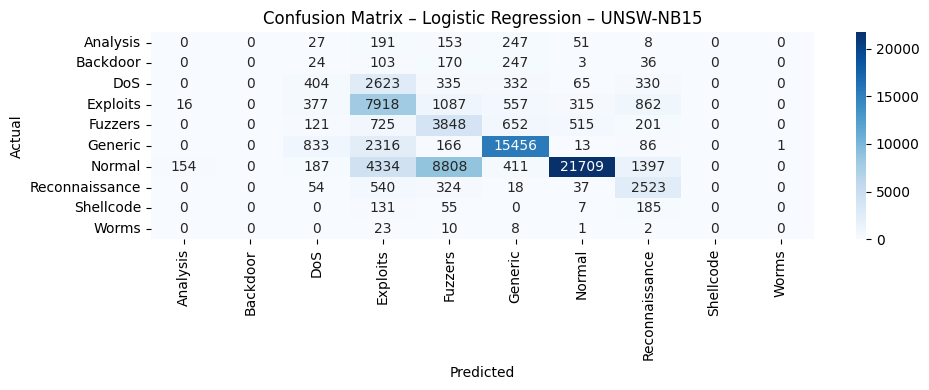

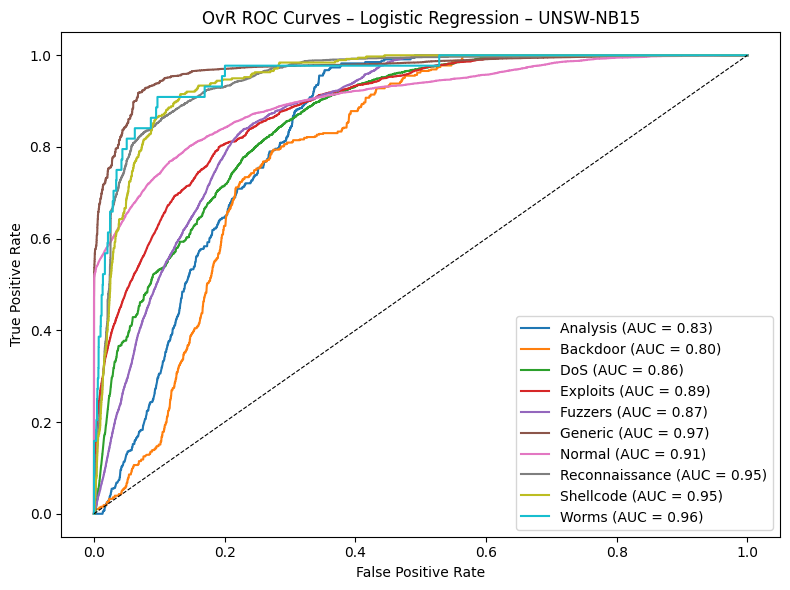

In [18]:
# ===============================
# Logistic-Regression – UNSW-NB15
# ===============================
pipe_lr_1 = make_pipeline(
    StandardScaler(with_mean=False),                 
    LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    )
)

pipe_lr_1.fit(X_train_1, y_train_1)
# Evaluate the model
evaluate_model(pipe_lr_1, X_test_1, y_test_1, "Logistic Regression – UNSW-NB15",le_unsw.classes_)


=== Logistic Regression – CIC UNSW-NB15 Augmented ===
Accuracy : 0.8937
Precision: 0.3496
Recall   : 0.3048
F1-score : 0.2979
F1-score(weighted) : 0.8918

Classification Report:
                precision    recall  f1-score   support

        Benign       0.99      0.97      0.98     71666
      Analysis       0.00      0.00      0.00        77
      Backdoor       0.00      0.00      0.00        90
           DoS       0.20      0.00      0.00       894
      Exploits       0.69      0.59      0.64      6190
       Fuzzers       0.43      0.76      0.55      5923
       Generic       0.61      0.14      0.23       927
Reconnaissance       0.58      0.58      0.58      3347
     Shellcode       0.00      0.00      0.00       420
         Worms       0.00      0.00      0.00        49

      accuracy                           0.89     89583
     macro avg       0.35      0.30      0.30     89583
  weighted avg       0.90      0.89      0.89     89583



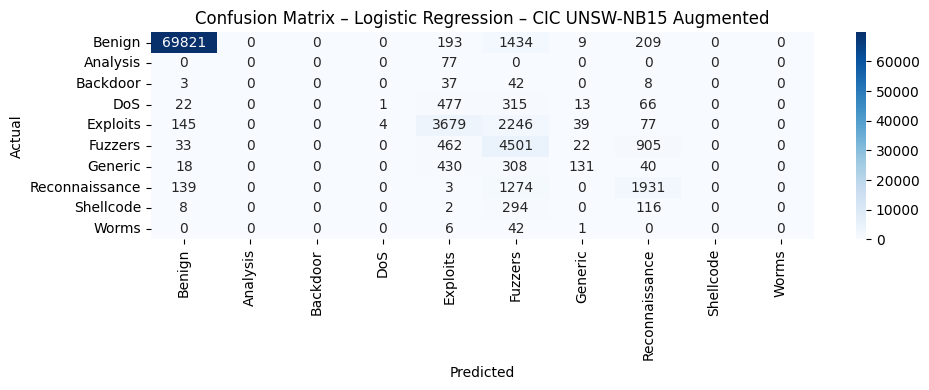

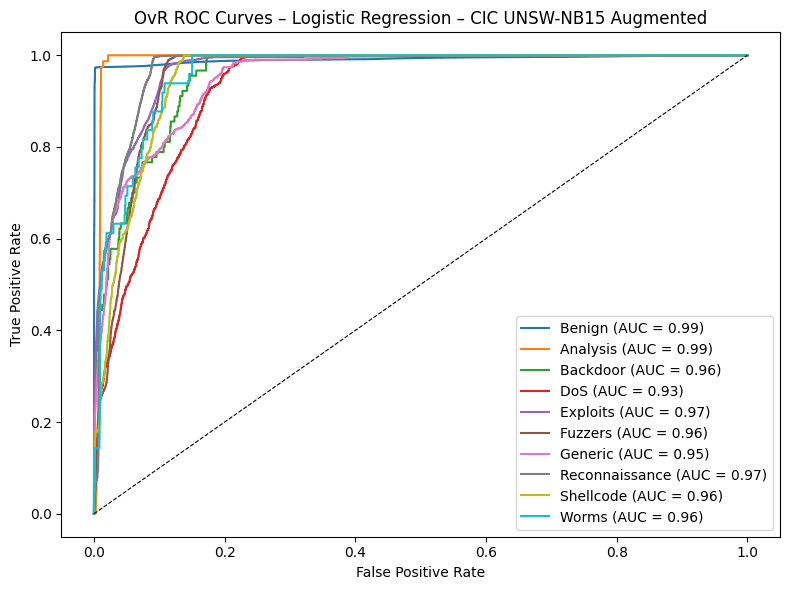

In [19]:
# =============================================
# Logistic-Regression – CIC UNSW-NB15 Augmented
# =============================================
pipe_lr_2 = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    )
)

pipe_lr_2.fit(X_train_2, y_train_2)
# Evaluate the model
evaluate_model(pipe_lr_2, X_test_2, y_test_2, "Logistic Regression – CIC UNSW-NB15 Augmented",label_names_cic)

### Random Forest


=== Random Forest – UNSW-NB15 ===
Accuracy : 0.7453
Precision: 0.5178
Recall   : 0.4897
F1-score : 0.4871
F1-score(weighted) : 0.7766

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.01      0.01      0.01       677
      Backdoor       0.01      0.10      0.03       583
           DoS       0.30      0.22      0.26      4089
      Exploits       0.74      0.66      0.70     11132
       Fuzzers       0.29      0.61      0.39      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.94      0.76      0.84     37000
Reconnaissance       0.90      0.79      0.84      3496
     Shellcode       0.42      0.51      0.46       378
         Worms       0.57      0.27      0.37        44

      accuracy                           0.75     82332
     macro avg       0.52      0.49      0.49     82332
  weighted avg       0.83      0.75      0.78     82332



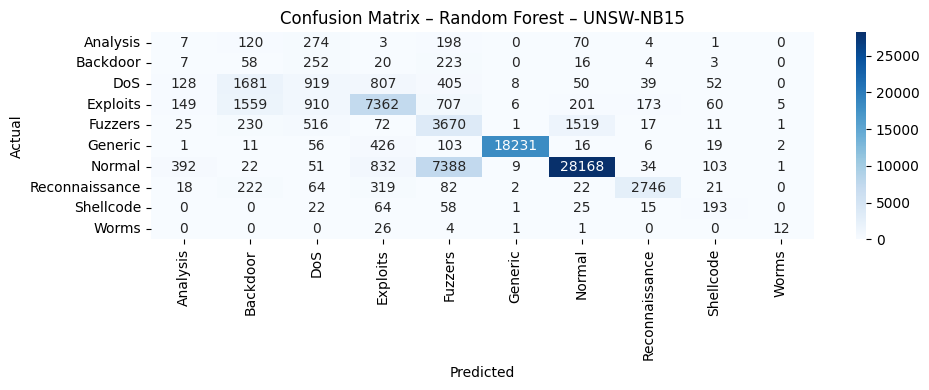

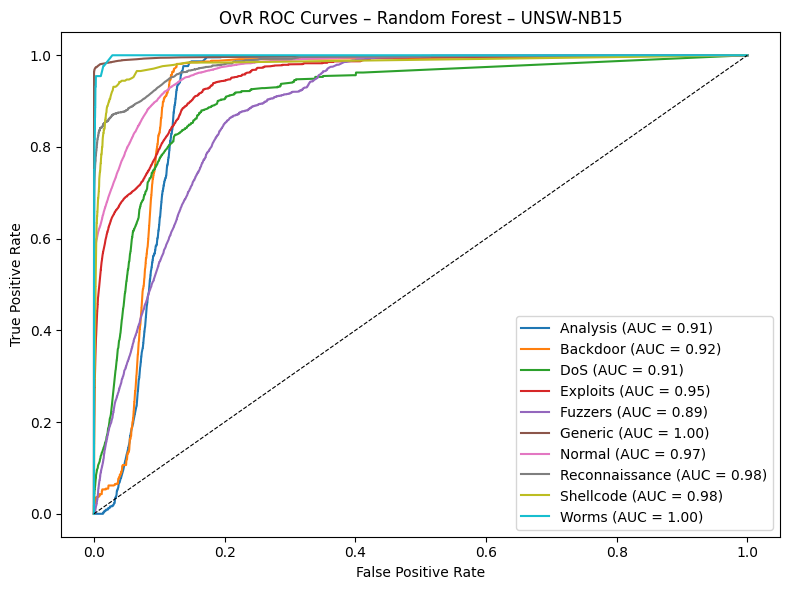

In [20]:
# =========================
# Random Forest – UNSW-NB15
# =========================
rf_unsw = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
rf_unsw.fit(X_train_1, y_train_1)

evaluate_model(
    rf_unsw,
    X_test_1,
    y_test_1,
    model_name="Random Forest – UNSW-NB15",
    class_names=le_unsw.classes_
)


=== Random Forest – CIC UNSW-NB15 Augmented ===
Accuracy : 0.9316
Precision: 0.6760
Recall   : 0.5778
F1-score : 0.6137
F1-score(weighted) : 0.9312

Classification Report:
                precision    recall  f1-score   support

        Benign       0.99      0.98      0.99     71666
      Analysis       0.28      0.23      0.26        77
      Backdoor       0.77      0.53      0.63        90
           DoS       0.61      0.30      0.41       894
      Exploits       0.75      0.79      0.77      6190
       Fuzzers       0.65      0.79      0.72      5923
       Generic       0.83      0.74      0.78       927
Reconnaissance       0.75      0.68      0.72      3347
     Shellcode       0.46      0.33      0.39       420
         Worms       0.66      0.39      0.49        49

      accuracy                           0.93     89583
     macro avg       0.68      0.58      0.61     89583
  weighted avg       0.93      0.93      0.93     89583



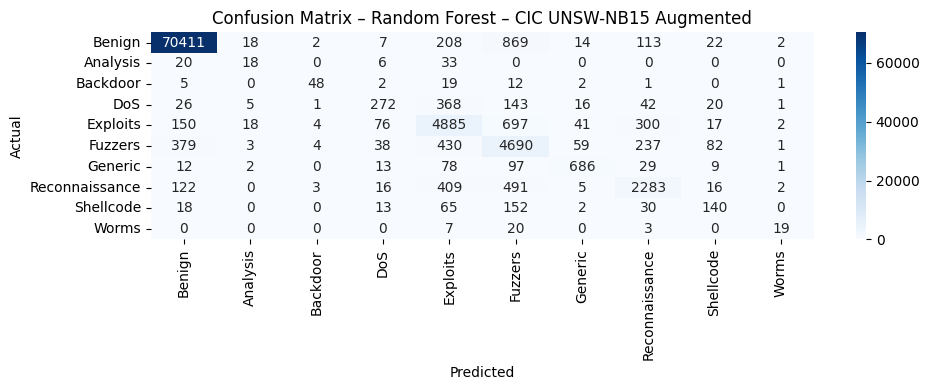

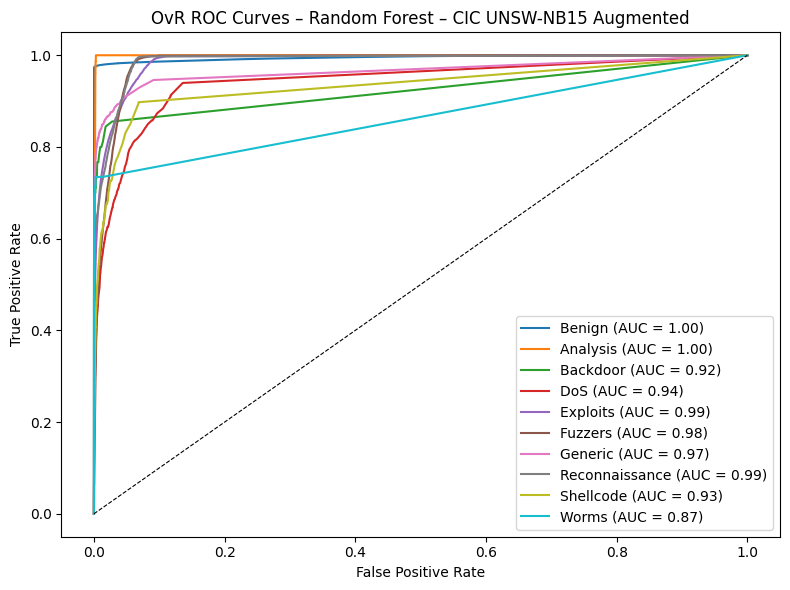

In [21]:
# =======================================
# Random Forest – CIC UNSW-NB15 Augmented
# =======================================
rf_cic = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
rf_cic.fit(X_train_2, y_train_2)

evaluate_model(
    rf_cic,
    X_test_2,
    y_test_2,
    model_name="Random Forest – CIC UNSW-NB15 Augmented",
    class_names=label_names_cic
)

### XGBoost


=== XGBoost – UNSW-NB15 ===
Accuracy : 0.7639
Precision: 0.5216
Recall   : 0.4980
F1-score : 0.4885
F1-score(weighted) : 0.7747

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.09      0.05      0.07       583
           DoS       0.33      0.12      0.18      4089
      Exploits       0.60      0.85      0.71     11132
       Fuzzers       0.29      0.61      0.39      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.94      0.75      0.84     37000
Reconnaissance       0.92      0.79      0.85      3496
     Shellcode       0.46      0.57      0.51       378
         Worms       0.58      0.25      0.35        44

      accuracy                           0.76     82332
     macro avg       0.52      0.50      0.49     82332
  weighted avg       0.81      0.76      0.77     82332



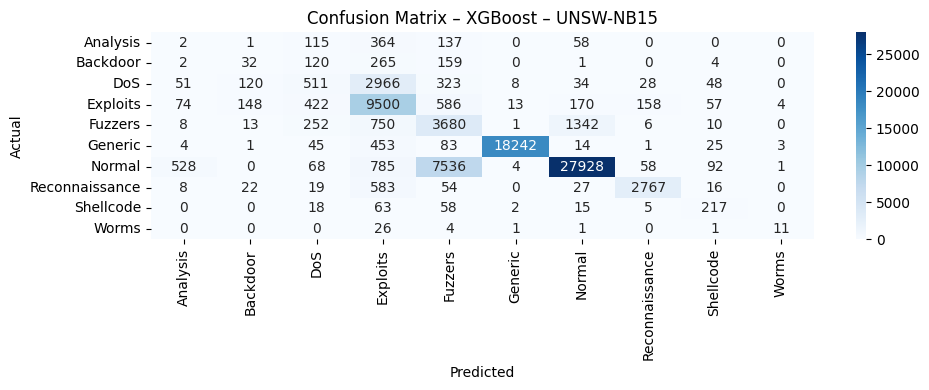

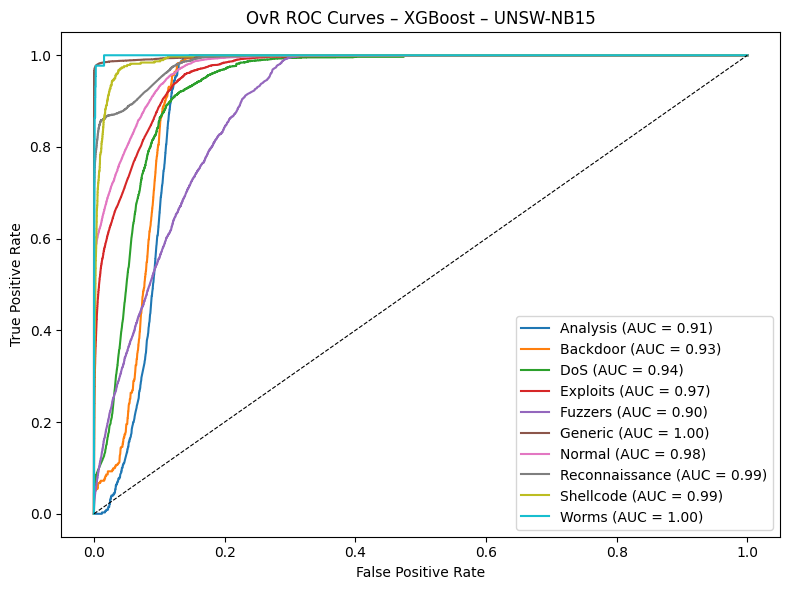

In [22]:
# ================================================================
# XGBoost  –  UNSW-NB15
# ================================================================

n_classes_unsw = len(np.unique(y_train_1))

xgb_unsw = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes_unsw,
    eval_metric="mlogloss",
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

xgb_unsw.fit(X_train_1, y_train_1)

evaluate_model(
    xgb_unsw,
    X_test_1,
    y_test_1,
    model_name="XGBoost – UNSW-NB15",
    class_names=le_unsw.classes_
)


=== XGBoost – CIC UNSW-NB15 Augmented ===
Accuracy : 0.9364
Precision: 0.7057
Recall   : 0.5666
F1-score : 0.6099
F1-score(weighted) : 0.9361

Classification Report:
                precision    recall  f1-score   support

        Benign       0.99      0.98      0.99     71666
      Analysis       0.33      0.30      0.32        77
      Backdoor       0.87      0.51      0.64        90
           DoS       0.71      0.28      0.40       894
      Exploits       0.79      0.77      0.78      6190
       Fuzzers       0.62      0.90      0.74      5923
       Generic       0.85      0.71      0.78       927
Reconnaissance       0.85      0.66      0.75      3347
     Shellcode       0.47      0.26      0.34       420
         Worms       0.56      0.29      0.38        49

      accuracy                           0.94     89583
     macro avg       0.71      0.57      0.61     89583
  weighted avg       0.94      0.94      0.94     89583



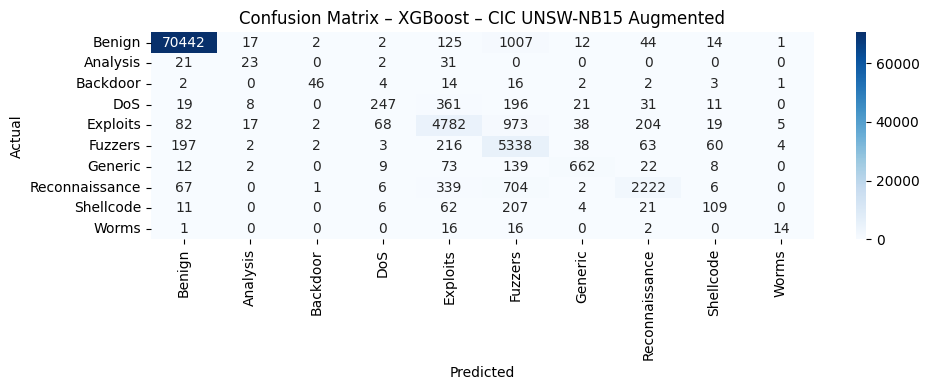

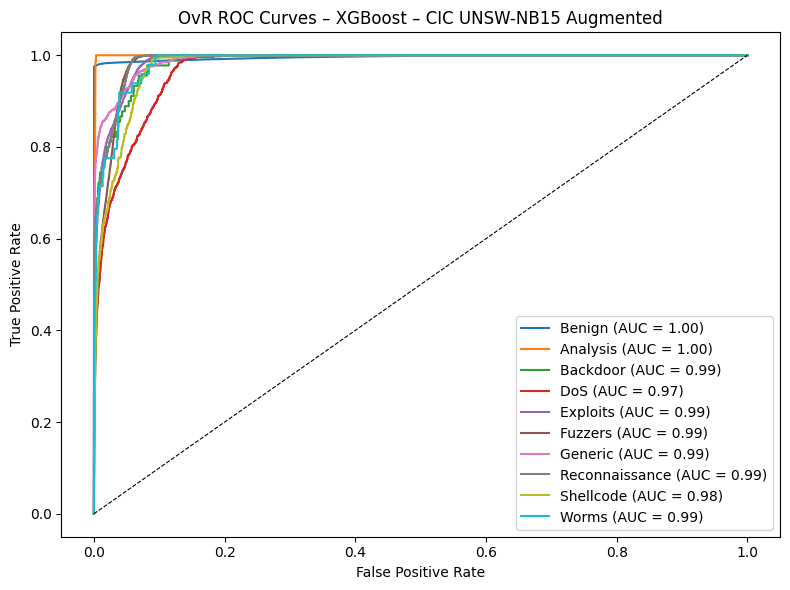

In [23]:
# ================================================================
# XGBoost  –  CIC UNSW-NB15 Augmented
# ================================================================
n_classes_cic = len(np.unique(y_train_2))

xgb_cic = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes_cic,
    eval_metric="mlogloss",
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

xgb_cic.fit(X_train_2, y_train_2)

evaluate_model(
    xgb_cic,
    X_test_2,
    y_test_2,
    model_name="XGBoost – CIC UNSW-NB15 Augmented",
    class_names=label_names_cic
)

### Neural Network


=== Neural Network – UNSW-NB15 ===
Accuracy : 0.7652
Precision: 0.5562
Recall   : 0.4416
F1-score : 0.4308
F1-score(weighted) : 0.7617

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.39      0.02      0.04       583
           DoS       0.53      0.04      0.07      4089
      Exploits       0.55      0.90      0.68     11132
       Fuzzers       0.29      0.48      0.36      6062
       Generic       0.99      0.96      0.98     18871
        Normal       0.93      0.78      0.85     37000
Reconnaissance       0.72      0.78      0.75      3496
     Shellcode       0.50      0.36      0.42       378
         Worms       0.67      0.09      0.16        44

      accuracy                           0.77     82332
     macro avg       0.56      0.44      0.43     82332
  weighted avg       0.80      0.77      0.76     82332



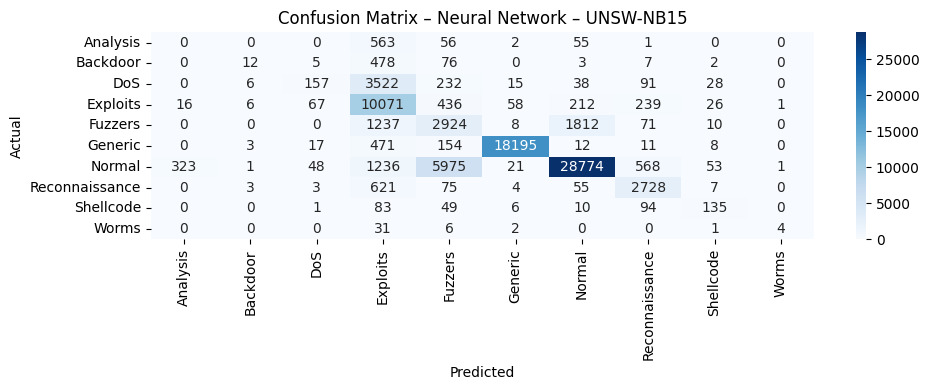

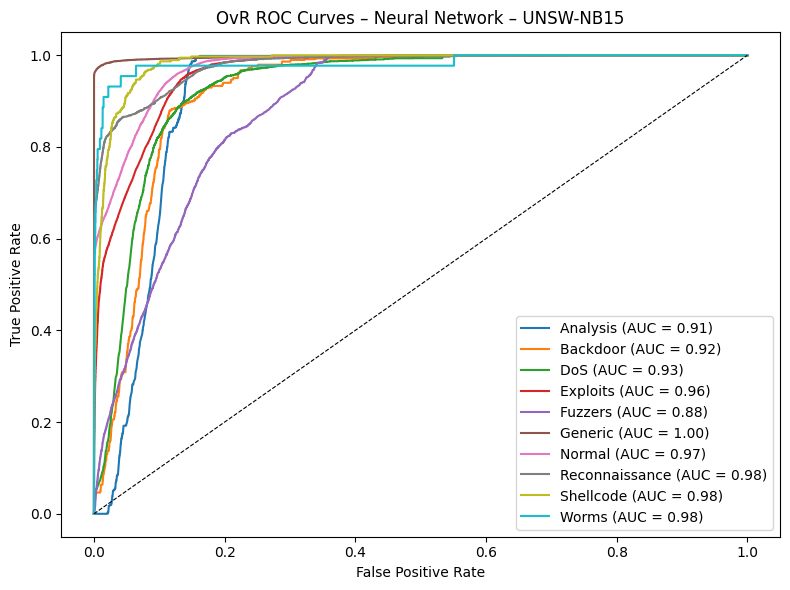

In [24]:
# ======================================================================
# Neural Network  –  UNSW-NB15
# ======================================================================
mlp_unsw = make_pipeline(
    StandardScaler(with_mean=False),
    MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        alpha=1e-4,
        max_iter=100,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        verbose=False
    )
)
mlp_unsw.fit(X_train_1, y_train_1)

evaluate_model(
    mlp_unsw,
    X_test_1,
    y_test_1,
    model_name="Neural Network – UNSW-NB15",
    class_names=le_unsw.classes_
)


=== Neural Network – CIC UNSW-NB15 Augmented ===
Accuracy : 0.9303
Precision: 0.6555
Recall   : 0.5199
F1-score : 0.5446
F1-score(weighted) : 0.9299

Classification Report:
                precision    recall  f1-score   support

        Benign       0.99      0.98      0.99     71666
      Analysis       0.31      0.52      0.39        77
      Backdoor       0.83      0.32      0.46        90
           DoS       0.57      0.21      0.31       894
      Exploits       0.74      0.76      0.75      6190
       Fuzzers       0.60      0.88      0.72      5923
       Generic       0.80      0.60      0.69       927
Reconnaissance       0.89      0.64      0.75      3347
     Shellcode       0.36      0.21      0.26       420
         Worms       0.44      0.08      0.14        49

      accuracy                           0.93     89583
     macro avg       0.66      0.52      0.54     89583
  weighted avg       0.94      0.93      0.93     89583



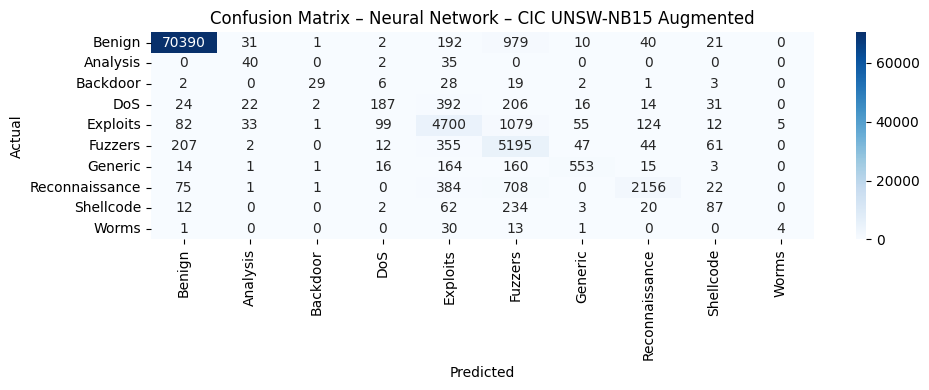

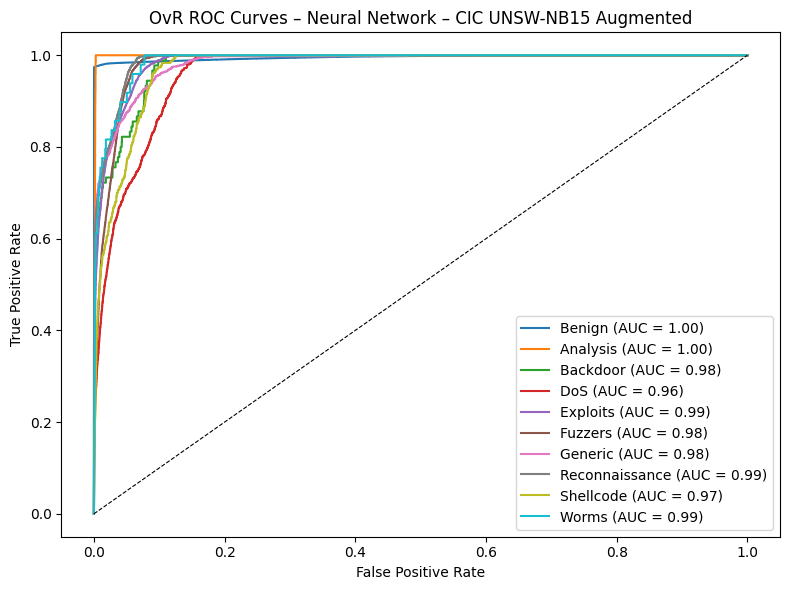

In [25]:
# ======================================================================
# Neural Network  –  CIC UNSW-NB15 Augmented
# ======================================================================

mlp_cic = make_pipeline(
    StandardScaler(with_mean=False),
    MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        alpha=1e-4,
        max_iter=100,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        verbose=False
    )
)
mlp_cic.fit(X_train_2, y_train_2)

evaluate_model(
    mlp_cic,
    X_test_2,
    y_test_2,
    model_name="Neural Network – CIC UNSW-NB15 Augmented",
    class_names=label_names_cic
)